In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
#from tqdm.notebook import tqdm
import gc
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import warnings
from torch.utils.data import Dataset, DataLoader
from wavenet import *
from wavenet2 import *
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

import os

In [16]:
EPOCHS = 90 #150
NNBATCHSIZE = 32
GROUP_BATCH_SIZE = 5000
SEED = 42
LR = 0.001
SPLITS = 5

outdir = 'wavenet_models'
device = "cpu"
# device = "cuda"
print("device:", device)
it = 5

device: cpu


In [17]:
# read data
def read_data():
    train = pd.read_csv('input/data-without-drift/train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv('input/data-without-drift/test_clean.csv', dtype={'time': np.float32, 'signal': np.float32})
    #from https://www.kaggle.com/sggpls/wavenet-with-shifted-rfc-proba and
    # https://www.kaggle.com/c/liverpool-ion-switching/discussion/144645
    Y_train_proba = np.load("input/ion-shifted-rfc-proba/Y_train_proba.npy")
    Y_test_proba = np.load("input/ion-shifted-rfc-proba/Y_test_proba.npy")
    for i in range(11):
        train[f"proba_{i}"] = Y_train_proba[:, i]
        test[f"proba_{i}"] = Y_test_proba[:, i]
        
    #sub  = pd.read_csv('input/sample_submission.csv', dtype={'time': np.float32})
    return train, test

# create batches of 4000 observations
def batching(df, batch_size):
    #print(df)
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean + 2.05) / (4.15*train_input_sigma)
    test['signal'] = (test.signal - train_input_mean + 2.05) / (4.15*train_input_sigma)
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    df['encode'] = encode_mu_law(df['signal'].values)
    return df

# fillna with the mean and select features for training
def feature_selection(test):
    features = [col for col in test.columns if col not in ['index', 'group', 'open_channels', 'time']]
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = test[feature].mean()
        test[feature] = test[feature].fillna(feature_mean)
    return test, features


def split(GROUP_BATCH_SIZE=4000):
    print('Reading Data Started...')
    train, test = read_data()
    train, test = normalize(train, test)
    test = run_feat_engineering(test, batch_size=GROUP_BATCH_SIZE)
    test, features = feature_selection(test)
    test = np.array(list(test.groupby('group').apply(lambda x: x[features].values)))
    return test


# class IronDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         data = self.data[idx]
#         labels = self.labels[idx]

#         return [data.astype(np.float32), labels.astype(int)]
class IronDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data = self.data[idx]
        onehot = np.eye(256)[data[:,-1].astype(int)]
        data = np.delete(data, -1, 1)
        data = np.concatenate([data, onehot], axis=1)
        labels = self.labels[idx]

        return [data.astype(np.float32), labels.astype(int)]

In [18]:
def make_dataset(train, slide=2000):
    ex_size = 500000
    n_iter = int(train.shape[0]/ex_size)
    for i in range(n_iter):
        if slide == 0:
            train_i = train.iloc[i*ex_size + slide: (i+1)*ex_size + slide].reset_index(drop=True)
        else:
            train_i = train.iloc[i*ex_size + slide: (i+1)*ex_size + slide - GROUP_BATCH_SIZE].reset_index(drop=True)
        train_i = run_feat_engineering(train_i, batch_size=GROUP_BATCH_SIZE)
        train_i, features = feature_selection(train_i)
        train_i = np.array(list(train_i.groupby('group').apply(lambda x: x[features].values)))
        if i == 0:
            X = train_i
        else:
            X = np.concatenate([X, train_i], 0)
    return X

In [19]:
train, test = read_data()
train, test = normalize(train, test)
test = run_feat_engineering(test, batch_size=GROUP_BATCH_SIZE)
test, features = feature_selection(test)
test

,time,signal,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,proba_10,group,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_2,encode
0,500.000092,-0.066101,0.970969,0.025847,0.002903,0.000281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,-0.085437,0.000000,-0.086467,0.000000,-0.045305,0.004369,60.0
1,500.000214,-0.085437,0.992143,0.007455,0.000335,0.000068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.066101,-0.086467,0.000000,-0.045305,0.000000,-0.062791,0.007299,55.0
2,500.000305,-0.086467,0.995843,0.003834,0.000271,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.085437,-0.045305,-0.066101,-0.062791,0.000000,-0.057989,0.007476,54.0
3,500.000397,-0.045305,0.994366,0.004576,0.001022,0.000036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.086467,-0.062791,-0.085437,-0.057989,-0.066101,-0.074643,0.002052,68.0
4,500.000488,-0.062791,0.994001,0.005714,0.000241,0.000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.045305,-0.057989,-0.086467,-0.074643,-0.085437,-0.078617,0.003943,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,699.999573,-0.091223,0.987027,0.011839,0.001096,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399,-0.083406,-0.075047,-0.074553,-0.083406,-0.078631,-0.091223,0.008322,53.0
1999996,699.999695,-0.075047,0.991047,0.007006,0.001906,0.000041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399,-0.091223,-0.083406,-0.083406,-0.091223,-0.074553,-0.075047,0.005632,57.0
1999997,699.999817,-0.083406,0.988469,0.010325,0.001158,0.000048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399,-0.075047,-0.091223,-0.091223,-0.075047,-0.083406,0.000000,0.006957,55.0
1999998,699.999878,-0.091223,0.982960,0.014041,0.002917,0.000082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399,-0.083406,-0.075047,-0.075047,0.000000,-0.091223,0.000000,0.008322,53.0


In [20]:
test = split(GROUP_BATCH_SIZE=GROUP_BATCH_SIZE)
print(test.shape)


Reading Data Started...
(400, 5000, 20)


In [21]:
# shift = 2000
# batch = int(500000/shift -1)
# test_s = np.zeros((int(test.shape[0]/shift -4), 4000, len(features)))
# print(test_s.shape)
# for j in range(4):
#     test_j = test.loc[j*500000: (j+1)*500000, features].reset_index(drop=True)
#     for i in range(batch):
#         test_s[j*batch + i] = test_j.iloc[i*shift: i*shift + 4000]
    
# print(test_s.shape)

In [22]:
test_y = np.zeros([test.shape[0], GROUP_BATCH_SIZE, 1])
test_dataset = IronDataset(test, test_y)
test_dataloader = DataLoader(test_dataset, NNBATCHSIZE, shuffle=False, num_workers=8, pin_memory=True)
test_preds_all = np.zeros((2000000, 11))


In [20]:
test_dataset[0][0].shape

(10000, 275)

In [26]:
264-9

255

In [13]:
# for fold in range(5):
#     checkpoint_path = "wavenet_models/checkpoint_it{0}_fold{1}.pt".format(it, fold)
#     model = Classifier(input_size=test_s.shape[2])
#     model.load_state_dict(torch.load(checkpoint_path, map_location=device))
#     model.to(device)
#     model.eval()
#     pred_list = []
#     cnt = 0
#     with torch.no_grad():
#         for x, _ in tqdm(test_dataloader):
#             x = x.to(device)
#             predictions = model(x)
#             if cnt == 0:
#                 predictions_ = predictions[0, :, :].reshape(1, -1, 11) # shape [1, 4000, 11]
#                 #predictions_ = predictions_.contiguous().view(-1, 11)
#                 predictions_ = predictions_.reshape(-1, 11)
#                 tmp = predictions[1:, shift:, :] #shape (batch, shift, 11)
#                 tmp = tmp.contiguous().view(-1, 11)
#                 #tmp = tmp.reshape(-1, 11)
#                 predictions_ = torch.cat([predictions_, tmp], dim=0)
#             elif cnt == 3:
#                 idx = np.ones(64).astype(bool)
#                 idx[57] = False
#                 tmp1 = predictions[57, :, :].reshape(1, -1, 11)
#                 tmp1 = tmp1.contiguous().view(-1, 11)
#                 #predictions_ = predictions_.reshape(-1, 11)
#                 tmp = predictions[idx, shift:, :] #shape (batch, shift, 11)
#                 tmp = tmp.contiguous().view(-1, 11)
#                 #tmp = tmp.reshape(-1, 11)
#                 predictions_ = torch.cat([predictions_, tmp1, tmp], dim=0)
#             elif cnt == 7:
#                 idx = np.ones(64).astype(bool)
#                 idx[10] = False
#                 tmp1 = predictions[10, :, :].reshape(1, -1, 11)
#                 tmp1 = tmp1.contiguous().view(-1, 11)
#                 #predictions_ = predictions_.reshape(-1, 11)
#                 tmp = predictions[idx, shift:, :] #shape (batch, shift, 11)
#                 tmp = tmp.contiguous().view(-1, 11)
#                 #tmp = tmp.reshape(-1, 11)
#                 predictions_ = torch.cat([predictions_, tmp1, tmp], dim=0)
#             elif cnt == 11:
#                 idx = np.ones(64).astype(bool)
#                 idx[43] = False
#                 tmp1 = predictions[43, :, :].reshape(1, -1, 11)
#                 tmp1 = tmp1.contiguous().view(-1, 11)
#                 #predictions_ = predictions_.reshape(-1, 11)
#                 tmp = predictions[idx, shift:, :] #shape (batch, shift, 11)
#                 tmp = tmp.contiguous().view(-1, 11)
#                 #tmp = tmp.reshape(-1, 11)
#                 predictions_ = torch.cat([predictions_, tmp1, tmp], dim=0)
#             else:
#                 tmp = predictions[:, shift:, :]
#                 tmp = tmp.contiguous().view(-1, 11)
#                 #tmp = tmp.reshape(-1, 11)
#                 predictions_ = torch.cat([predictions_, tmp], dim=0)
#             cnt += 1
#         test_preds = F.softmax(predictions_, dim=1).cpu().numpy() # shape (200000, 11)
#         test_preds_all += test_preds




In [14]:
print('Generate submission.............')
submission_csv_path = 'input/sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds_all / np.sum(test_preds_all, axis=1)[:, None]
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str),
                                'open_channels': np.argmax(test_preds_all, axis=1)})
test_pred_frame.to_csv("output/preds_it{}_e.csv".format(it), index=False)
print('over')

Generate submission.............
over


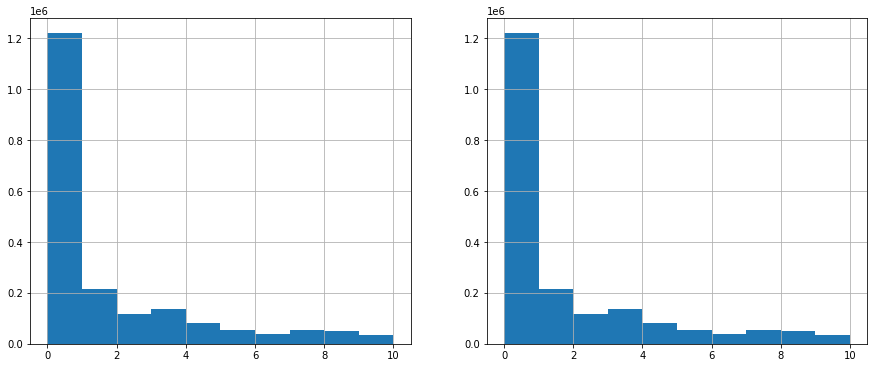

In [21]:
it = 12
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
# a = pd.read_csv('output/preds_it{}.csv'.format(it))
# a.open_channels.hist()
a = pd.read_csv('output/preds_1.csv')
a.open_channels.hist()
plt.subplot(1,2,2)
b = pd.read_csv('output/preds_it{}.csv'.format(it))
b.open_channels.hist()

In [9]:
ans = np.zeros((5,5))
it = 111
for i in range(5):
    # if i == 2 or i == 4:
    #     continue
    ans[i] = pd.read_csv('logs/log_it{0}_{1}.csv'.format(it, i)).iloc[-1]
# ans.sum(axis=0)/3
pd.DataFrame(ans, columns=cols)


NameError: name 'cols' is not defined

In [15]:
cols = ["loss", "F1", "val_loss", "val_F1", "lr"]
ans = np.zeros((5,5))
it = 111
for i in range(5):
    # if i in [1,2,4]:
    #     continue
    ans[i] = pd.read_csv('logs/log_it{0}_{1}.csv'.format(it, i)).iloc[-1]
pd.DataFrame(ans, columns=cols)
ans.sum(axis=0)/5

array([1.99924853e+05, 9.38186360e-01, 1.78583617e+05, 9.37272848e-01,
       7.62939453e-08])

In [43]:
test_y = np.zeros([int(2000000/GROUP_BATCH_SIZE), GROUP_BATCH_SIZE, 1])
test_dataset = IronDataset(test, test_y)
test_dataloader = DataLoader(test_dataset, NNBATCHSIZE, shuffle=False, num_workers=8, pin_memory=True)
test_preds_all = np.zeros((2000000, 11))

folds = [0,  3]
it = 5
for fold in folds:
    checkpoint_path = "wavenet_models/checkpoint_it{0}_fold{1}.pt".format(it, fold)
    model = Classifier(input_size=test.shape[2])
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    pred_list = []
    with torch.no_grad():
        for x, y in tqdm(test_dataloader):
            x = x.to(device)
            y = y.to(device)

            predictions = model(x)
            predictions_ = predictions.view(-1, predictions.shape[-1]) # shape [128, 4000, 11]
            #print(predictions.shape, F.softmax(predictions_, dim=1).cpu().numpy().shape)
            pred_list.append(F.softmax(predictions_, dim=1).cpu().numpy()) # shape (512000, 11)
        test_preds = np.vstack(pred_list) # shape [2000000, 11]
        test_preds_all += test_preds


In [44]:
submission_csv_path = 'input/sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds_all / np.sum(test_preds_all, axis=1)[:, None]
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str),
                                'open_channels': np.argmax(test_preds_all, axis=1)})
test_pred_frame.to_csv("output/preds_it{}_sel.csv".format(it), index=False)
print('over')

over


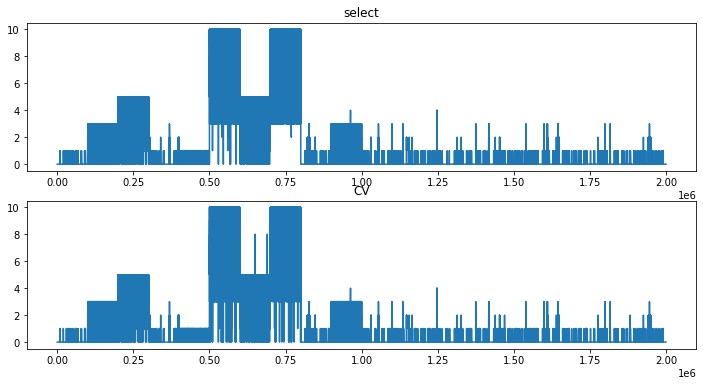

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('select')
test_pred_frame['open_channels'].plot()
plt.subplot(2,1,2)
plt.title('CV')
pd.read_csv('output/preds_it6.csv')["open_channels"].plot()

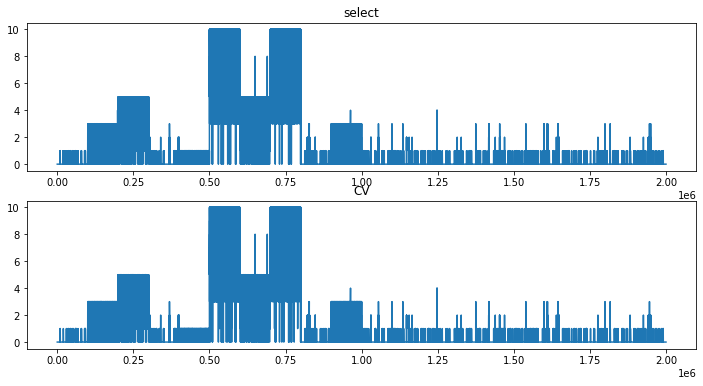

In [47]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('select')
pd.read_csv('output/preds_it6_sel.csv')["open_channels"].plot()
plt.subplot(2,1,2)
plt.title('CV')
pd.read_csv('output/preds_it6.csv')["open_channels"].plot()

In [66]:
# log = pd.read_csv("logs/log_it6_0.csv")
# log

In [69]:
test.shape
_, test_1 = read_data()

In [74]:
a = test[0]

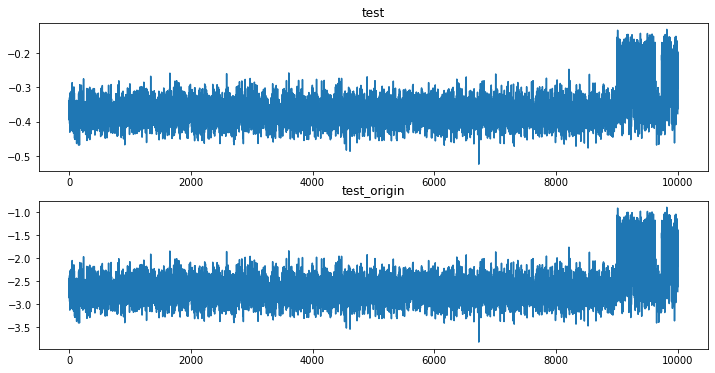

In [75]:
b = test_1["signal"].values
b = b[:10000]
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('test')
plt.plot(a[:,0])
plt.subplot(2,1,2)
plt.title('test_origin')
plt.plot(b)

In [72]:
aa = encode_mu_law(a[])

In [73]:
aa

array([23, 21, 21, ..., 35, 35, 22])

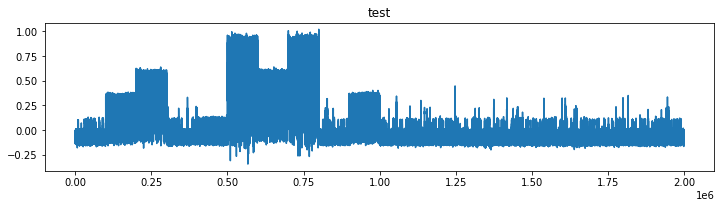

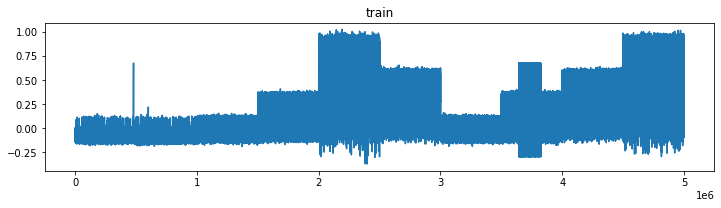

In [139]:
train, test_1 = read_data()
train, test_1 = normalize(train, test_1)
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('test')
test_1.signal.plot()
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('train')
train.signal.plot()

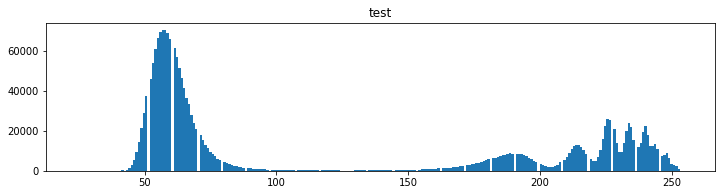

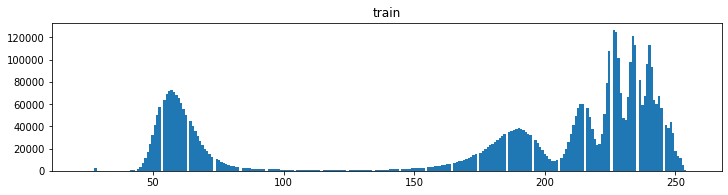

In [140]:
train_e = encode_mu_law(train.signal.values)
test_e = encode_mu_law(test_1.signal.values)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('test')
_=plt.hist(test_e, bins=256)
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('train')
_=plt.hist(train_e, bins=256)

In [20]:
train["open_shift"] = train['open_channels'].shift(1).fillna(0).astype(int)


In [22]:
from sklearn.metrics import f1_score

train_score = f1_score(train['open_channels'].values, train["open_shift"].values,
                               labels=list(range(11)), average='macro')

In [24]:
train_score

0.5976691171001121

In [25]:
train_dataset = IronDataset(train, train_tr)

NameError: name 'train_tr' is not defined